# Develop `wave_height_period` Figure Module

Development of functions for `nowcast.figures.wwatch3.wave_height_period` web site figure module.

In [1]:
from pathlib import Path
from types import SimpleNamespace

import matplotlib.dates
import matplotlib.pyplot as plt
import moad_tools.observations
import moad_tools.places
import requests
import xarray

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_prep_plot_data()` Function

In [3]:
def _prep_plot_data(buoy, wwatch3_dataset_url):
    wwatch3_fields = xarray.open_dataset(wwatch3_dataset_url)
    wwatch3 = xarray.Dataset({
        'wave_height': wwatch3_fields.hs.sel(
            longitude=moad_tools.places.PLACES[buoy]["lon lat"][0] + 360,
            latitude=moad_tools.places.PLACES[buoy]["lon lat"][1],
            method='nearest',
        ),
        'peak_freq': wwatch3_fields.fp.sel(
            longitude=moad_tools.places.PLACES[buoy]["lon lat"][0] + 360,
            latitude=moad_tools.places.PLACES[buoy]["lon lat"][1],
            method='nearest',
        ),
    })
    wwatch3_period = slice(
        str(wwatch3_fields.time.data[0]), str(wwatch3_fields.time.data[-1])
    )
    obs = moad_tools.observations.get_ndbc_buoy(buoy)
    obs = xarray.Dataset({
                "wave_height": obs.loc[wwatch3_period, ("WVHT", "m")],
                "dominant_period": obs.loc[wwatch3_period, ("DPD", "sec")],
    })
    # Change dataset times to Pacific time zone
    shared.localize_time(wwatch3)
    shared.localize_time(obs)
    return SimpleNamespace(
        wwatch3=wwatch3,
        obs=obs,
    )

## `_prep_fig_axes() Function`

In [4]:
def _prep_fig_axes(figsize, theme):
    fig, (ax_sig_height, ax_peak_freq) = plt.subplots(
        2, 1, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    fig.autofmt_xdate()
    return fig, (ax_sig_height, ax_peak_freq)


## `_plot_wave_height_time_series()` Function

In [5]:
def _plot_wave_height_time_series(ax, place, plot_data, theme):
    plot_data.obs.wave_height.plot(
        ax=ax,
        marker=".",
        linestyle="None",
        label="ECCC Observed",
        markerfacecolor=theme.COLOURS["time series"]["obs wave height"],
        markeredgecolor=theme.COLOURS["time series"]["obs wave height"],
    )
    plot_data.wwatch3.wave_height.plot(
        ax=ax,
        linewidth=2,
        label='WaveWatch3',
        color=theme.COLOURS['time series']['wave height'],
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _wave_height_time_series_labels(ax, place, plot_data, theme)

## `_wave_height_time_series_labels()` Function

In [6]:
def _wave_height_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Significant Wave Height at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_ylabel(
        'Significant Wave Height [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)

## `_plot_dominant_period_time_series()` Function

In [7]:
def _plot_dominant_period_time_series(ax, place, plot_data, theme):
    plot_data.obs.dominant_period.plot(
        ax=ax,
        marker=".",
        linestyle="None",
        label="ECCC Observed",
        markerfacecolor=theme.COLOURS["time series"]["obs wave height"],
        markeredgecolor=theme.COLOURS["time series"]["obs wave height"],
    )
    (1/plot_data.wwatch3.peak_freq).plot(
        ax=ax,
        linewidth=2,
        label='WaveWatch3',
        color=theme.COLOURS['time series']['wave period'],
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _dominant_period_time_series_labels(ax, place, plot_data, theme)

## `_dominant_period_time_series_labels()` Function

In [8]:
def _dominant_period_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Dominant Wave Period at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_xlabel(
        f'Time [{plot_data.wwatch3.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    ax.set_ylabel(
        'Dominant Wave Period [s]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [9]:
def make_figure(
    buoy,
    wwatch3_dataset_url,
    figsize=(16, 9),
    theme=nowcast.figures.website_theme,
):
    plot_data = _prep_plot_data(buoy, wwatch3_dataset_url)
    fig, (ax_sig_height, ax_peak_freq) = _prep_fig_axes(figsize, theme)
    _plot_wave_height_time_series(ax_sig_height, buoy, plot_data, theme)
    _plot_dominant_period_time_series(ax_peak_freq, buoy, plot_data, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

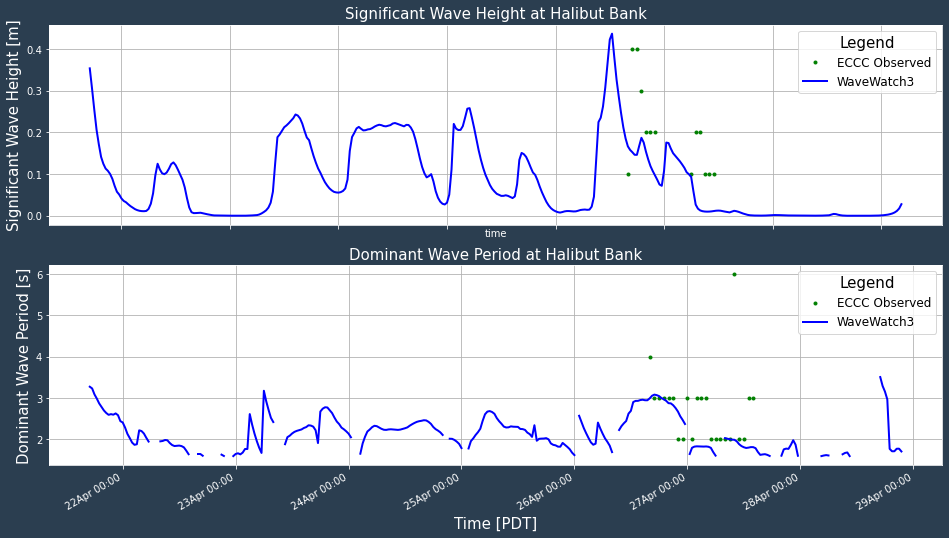

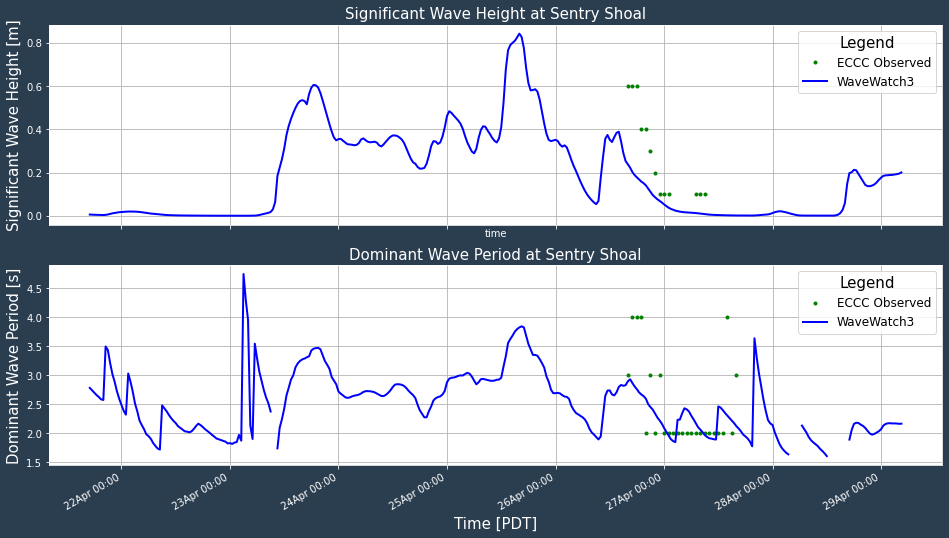

In [10]:
# %%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

wwatch3_dataset_url = (
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf2DWaveFields30mV17-02'
)

fig = make_figure('Halibut Bank', wwatch3_dataset_url)
fig = make_figure('Sentry Shoal', wwatch3_dataset_url)